# Multinomial RANCH Project Notebook

#### Author: Guanpeng (Andy) Xu
#### 9.660 Final Project, Fall 2023

## Imports

In [19]:
import numpy as np

import pandas as pd

from scipy.special import gammaln as loggamma, digamma
from matplotlib import pyplot as plt

from tqdm import trange

## Exemplars and Priors

In [20]:
exemplars =  np.array([[0,0,0], [0,0,1], [0,1,2], [1,2,3]]).astype(float) #feature values 0,1,2,3,4
default_exemplars = np.array([np.array([0,0,1]).astype(float) for i in range(6)]).astype(float)

deviant_exemplar = np.array([4,0,0]).astype(float)

full_alphas_1 = np.array([[4, 1, 1, 1, 1],
       [4, 1, 1, 1, 1],
       [4, 1, 1, 1, 1]]).astype(float)
full_alphas_2 = np.array([[3.6, 3.6, 3.6, 3.6, 3.6],
       [3.6, 3.6, 3.6, 3.6, 3.6],
       [3.6, 3.6, 3.6, 3.6, 3.6]]).astype(float) - 2.0

full_alphas_3 = np.array([[0.04, 1.99, 1.99, 1.99, 1.99],
       [0.04, 1.99, 1.99, 1.99, 1.99],
       [0.04, 1.99, 1.99, 1.99, 1.99]]).astype(float)

full_alphas_1

array([[4., 1., 1., 1., 1.],
       [4., 1., 1., 1., 1.],
       [4., 1., 1., 1., 1.]])

## RANCH implementation

In [21]:
epsilon_ = 0.065
epsilons = [0.001, 0.01, 0.1, 0.2, 0.5, 0.7]
epsilon_hat = 0.065
EIG_env_ = 0.01
numft, numval = full_alphas_1.shape


def perturb(exemplar, epsilon = epsilon_hat):
    rand_arr = np.random.rand(numft)
    out = []
    for ind in range(numft):
        if rand_arr[ind] >= epsilon:
            out.append(exemplar[ind])
        else:
            permute = 1 + int(4* rand_arr[ind]/epsilon) 
            out.append( (exemplar[ind] + permute)%5) 
        pass
    return np.array(out)

def compute_posterior_change(zs, epsilon):
    
    if len(zs) == 0:
        return 1.0 * (np.ones((numval, ))/numval).astype(float)

    
    assert epsilon > 0
    assert epsilon < 1
    ci = np.ones((len(zs), numval)).astype(float) * np.log((epsilon/(numval - 1)))
    
    #each row is a z, each column is a feature value for y.
    ci[[i for i in range(len(zs))], [int(x+ 0.001) for x in zs]] = np.log(1 - epsilon)
    ci_out = np.sum(ci, axis = 0)
    
    assert ci_out.shape[0] == numval
    return np.exp(ci_out)/np.sum(np.exp(ci_out))


def EIG(alpha_priors, zs, epsilon = epsilon_):
    
    M = (1 - (numval * epsilon/(numval-1))) * np.eye(numval) + (epsilon/(numval - 1)) * np.ones((numval, numval))
    
    pi = compute_posterior_change(zs, epsilon)
    
    di = np.matmul(M, pi)
    
    probs = (di+alpha_priors)
    probs = probs/np.sum(probs)
    
    EIG_ = 0
    
    for val in range(numval):
        post_change = compute_posterior_change(zs + [val], epsilon)
        EIG_ += KL(alpha_priors + post_change, alpha_priors + pi) * probs[val]

    return EIG_


def KL(alphas_1, alphas_2):
    
    loggamma1 = loggamma(np.sum(alphas_1))
    loggamma2 = loggamma(np.sum(alphas_2))
    loggamma3 = np.sum(loggamma(alphas_1))
    loggamma4 = np.sum(loggamma(alphas_2))
    diffs = alphas_1 - alphas_2
    digamma_diffs = digamma(alphas_1) - digamma(np.sum(alphas_1))
    
    return (loggamma1 - loggamma2) + (loggamma4 - loggamma3) + np.dot(diffs, digamma_diffs)


def ranch_sample(alpha_priors = full_alphas_1, exemplar_sequence = default_exemplars[:1], epsilon = epsilon_hat, EIG_env = EIG_env_):
    
    """
    Return a sequence of looking times for each exemplar in the sequence, given a set of input priors and epsilon.
    """
    
    priors_modify = alpha_priors.copy()[:,:].astype(float)
    out_array = []
    
    observations_so_far = []
    
    for exemplar in exemplar_sequence:
        
        r = 0 
        
        observations_so_far.append([])
        sample = True
        
        while (sample and r < 5000): 
            z = perturb(exemplar, epsilon)
            
            EIG_next = 0
            
            for ft in range(numft):
                zs_ft = [z[ft] for z in observations_so_far[-1]]
                alphas_ft = priors_modify[ft,:].copy()
                EIG_next += EIG(alphas_ft, zs_ft, epsilon)
                
            if (EIG_env + EIG_next) * np.random.rand() > EIG_next:
                sample = False
            r += 1
            if r == 2500:
                print('2500 iters done. EIG: ', EIG_next)
                
            if r == 5000:
                print('Fail ', EIG_next)
                
            observations_so_far[-1].append(z)
            
        out_array.append(r)
        for ft in range(numft):
            zs_ft = [z[ft] for z in observations_so_far[-1]]
            priors_modify[ft] += compute_posterior_change(zs_ft, epsilon)
    
    return np.array(out_array)




## Multinomial RANCH Properties

In [22]:
seq_dict_e = {}
seq_dict_EIG = {}
seq_dict_alphas = {}

for epsilon__ in epsilons:
    print('EPS: ', epsilon__)
    for l in trange(1000): #10000
        seq_dict_e[epsilon__] = seq_dict_e.get(epsilon__, 0) +  0.001 * ranch_sample(epsilon = epsilon__)
    
print('')
print('') 
for EIG_env__ in [0.001, 0.01, 0.1]:
    print('EIG_env: ', EIG_env__)
    for l in trange(1000): #10000
        seq_dict_EIG[EIG_env__] =seq_dict_EIG.get(EIG_env__, 0) + 0.001 * ranch_sample(EIG_env = EIG_env__)
print('')
print('')  
for i, alpha_arr in enumerate([full_alphas_1, full_alphas_2, full_alphas_3]):
    print('ALPHA_ARR: ', alpha_arr[0])
    for l in trange(10000):
        seq_dict_alphas[i] = seq_dict_alphas.get(i, 0) + 0.0001 * ranch_sample(alpha_priors = alpha_arr.copy())


EPS:  0.001


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 421.94it/s]


EPS:  0.01


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 408.17it/s]


EPS:  0.1


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 320.80it/s]


EPS:  0.2


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 260.18it/s]


EPS:  0.5


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.12it/s]


EPS:  0.7


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 502.19it/s]




EIG_env:  0.001


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.98it/s]


EIG_env:  0.01


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 352.74it/s]


EIG_env:  0.1


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 454.89it/s]




ALPHA_ARR:  [4. 1. 1. 1. 1.]


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 354.53it/s]


ALPHA_ARR:  [1.6 1.6 1.6 1.6 1.6]


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 351.07it/s]


ALPHA_ARR:  [0.04 1.99 1.99 1.99 1.99]


100%|██████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 328.33it/s]


In [23]:
seq_dict_e

{0.001: array([2.944]),
 0.01: array([3.042]),
 0.1: array([3.873]),
 0.2: array([4.674]),
 0.5: array([6.286]),
 0.7: array([2.453])}

In [24]:
seq_dict_EIG

{0.001: array([3.985]), 0.01: array([3.557]), 0.1: array([2.762])}

In [25]:
seq_dict_alphas

{0: array([3.523]), 1: array([3.544]), 2: array([3.771])}

### Plotting

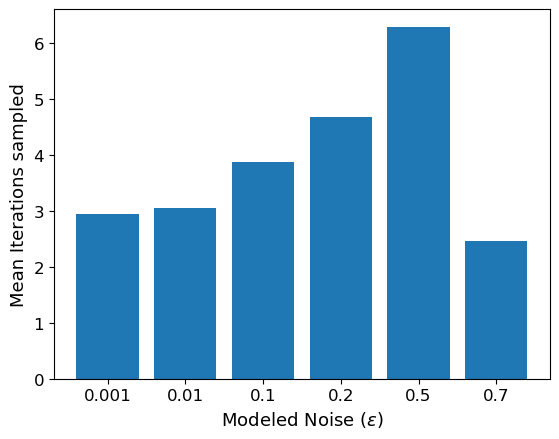

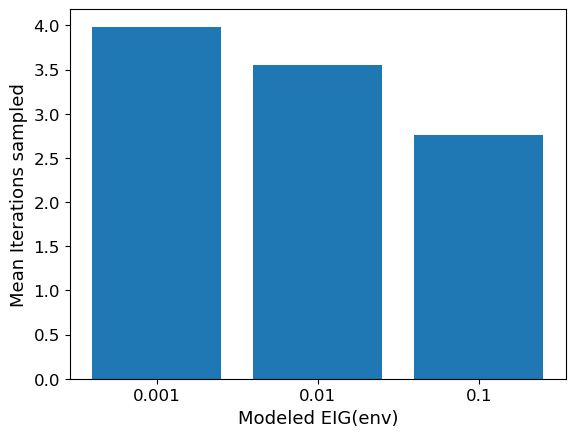

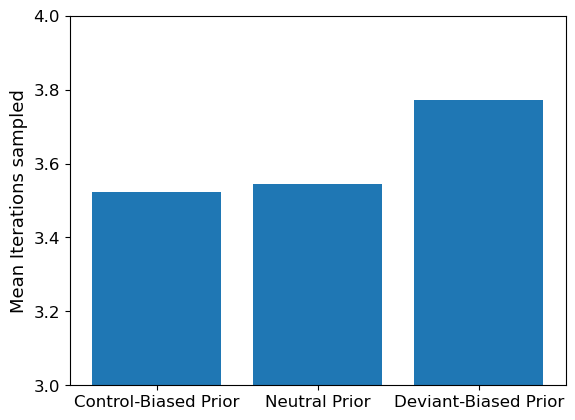

In [26]:
def plot_dict(dict_):
    names = []
    values = []
    
    for key in dict_:
        names.append(str(key))
        values.append(dict_[key][0])
        
    return names,values

plt.bar(plot_dict(seq_dict_e)[0], plot_dict(seq_dict_e)[1])
plt.xlabel('Modeled Noise $(\epsilon)$' , fontsize = 13)
plt.ylabel('Mean Iterations sampled', fontsize = 13)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

plt.bar(plot_dict(seq_dict_EIG)[0], plot_dict(seq_dict_EIG)[1])
plt.xlabel('Modeled EIG(env)', fontsize = 13)
plt.ylabel('Mean Iterations sampled', fontsize = 13)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

plt.bar(['Control-Biased Prior', 'Neutral Prior', 'Deviant-Biased Prior'], plot_dict(seq_dict_alphas)[1] )

plt.ylim(3, 4)

plt.ylabel('Mean Iterations sampled', fontsize = 13)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

## Complexity/Habituation Analysis

### WARNING:
The below does not replicate well unless we use ~100000 samples per run (std of each exemplar ~1, and we want to distiguish below the 0.01 level). This takes about 30 minutes per run. Therefore, we run 10000 samples below in the notebook and accept some variance.

In [27]:
num_runs = 10000

In [28]:
compl = {}

for i in range(4):
    arr = np.array([exemplars[i].copy() for t in range(6) ])
    print(arr)

    for l in trange(num_runs): 
        compl[str(arr[0] + 1)] = compl.get(str(arr[0] + 1), 0) + (1.0/num_runs)* ranch_sample(exemplar_sequence = arr)
    

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [02:49<00:00, 58.83it/s]


[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [02:53<00:00, 57.76it/s]


[[0. 1. 2.]
 [0. 1. 2.]
 [0. 1. 2.]
 [0. 1. 2.]
 [0. 1. 2.]
 [0. 1. 2.]]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [02:50<00:00, 58.64it/s]


[[1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [02:48<00:00, 59.40it/s]


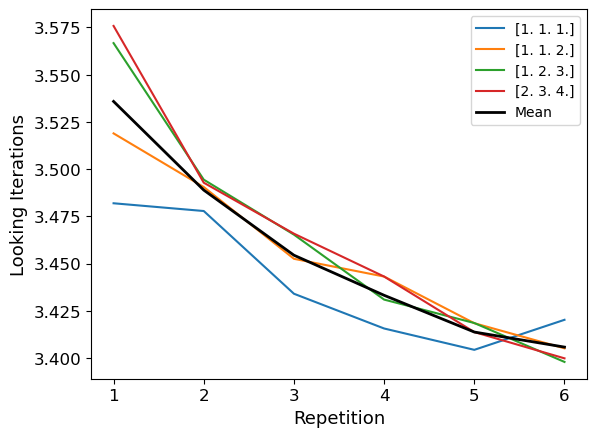

In [29]:
for key in compl:   
    plt.plot([1,2,3,4,5,6], compl[key], label = key)
    
means = []

for i in range(6):
    means.append(0)
    for key in compl:
        means[-1] += 0.25 *compl[key][i]
plt.plot([1,2,3,4,5,6], means, label = 'Mean', color = 'black', linewidth = 2)
plt.legend()  
plt.xlabel('Repetition', fontsize = 13)
plt.ylabel('Looking Iterations', fontsize = 13)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

## Dishabituation Analysis

In [30]:
num_runs = 10000

In [31]:
dishab = {}


arr = ([exemplars[1].copy() for t in range(6) ])
print(arr)

for l in trange(num_runs):
    dishab['Control'] = dishab.get('Control', 0) + (1.0/num_runs) * ranch_sample(alpha_priors = full_alphas_1, exemplar_sequence = arr)

arr = ([exemplars[1].copy() for t in range(1) ] + [deviant_exemplar.copy() for t in range(1) ] + [exemplars[1].copy() for t in range(4) ] )
print(arr)

for l in trange(num_runs):
    dishab['Deviant #2'] = dishab.get('Deviant #2', 0) + (1.0/num_runs) * ranch_sample(alpha_priors = full_alphas_1,exemplar_sequence = arr)


arr = ([exemplars[1].copy() for t in range(3) ] + [deviant_exemplar.copy() for t in range(1) ] + [exemplars[1].copy() for t in range(2) ] )
print(arr)

for l in trange(num_runs):
    dishab['Deviant #4'] = dishab.get('Deviant #4', 0) + (1.0/num_runs) * ranch_sample(alpha_priors = full_alphas_1,exemplar_sequence = arr)

    
arr = ([exemplars[1].copy() for t in range(5) ] + [deviant_exemplar.copy() for t in range(1) ] + [exemplars[1].copy() for t in range(0) ] )
print(arr)

for l in trange(num_runs):
    dishab['Deviant #6'] = dishab.get('Deviant #6', 0) + (1.0/num_runs) * ranch_sample(alpha_priors = full_alphas_1,exemplar_sequence = arr)


[array([0., 0., 1.]), array([0., 0., 1.]), array([0., 0., 1.]), array([0., 0., 1.]), array([0., 0., 1.]), array([0., 0., 1.])]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [02:51<00:00, 58.47it/s]


[array([0., 0., 1.]), array([4., 0., 0.]), array([0., 0., 1.]), array([0., 0., 1.]), array([0., 0., 1.]), array([0., 0., 1.])]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [02:55<00:00, 57.13it/s]


[array([0., 0., 1.]), array([0., 0., 1.]), array([0., 0., 1.]), array([4., 0., 0.]), array([0., 0., 1.]), array([0., 0., 1.])]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [02:54<00:00, 57.19it/s]


[array([0., 0., 1.]), array([0., 0., 1.]), array([0., 0., 1.]), array([0., 0., 1.]), array([0., 0., 1.]), array([4., 0., 0.])]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [02:54<00:00, 57.35it/s]


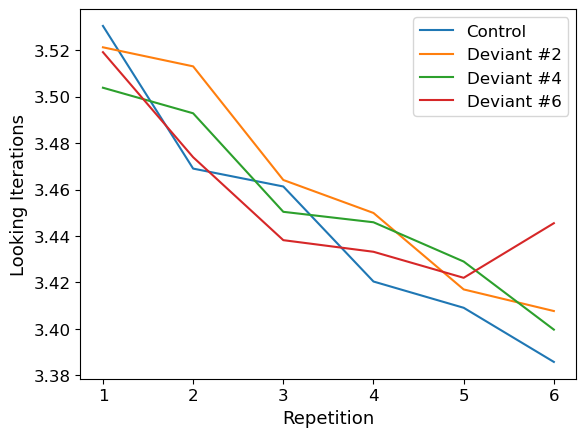

In [32]:
for key in dishab:
    plt.plot([1,2,3,4,5,6],  dishab[key], label = key)
    plt.legend(fontsize = 12)
    
plt.xlabel('Repetition', fontsize = 13)
plt.ylabel('Looking Iterations', fontsize = 13)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()